# Global Temperatures and Sea Level Rise
The purpose of this project is to find a relationship between global temperatures and sea level rise. The data collected will be pulled from two datasets. One describes the surface temperatures around the world created by Berkeley Earth and Kristen sissener and the other describing the sea level over time collected by climate.gov and Jarred Priester. The dataset about the temperatures collects data consistently from month to month from 1743 to 2013. It collects both global temperatures and regional temperatures. The dataset about sea level collects data annually from 1880 to 2020. This data contains the difference in sea level in millimeters below the average sea level from 1993 til 2008. By pooling this data we are able to use the combined information to compare side by side the rise in global and regional temperatures and the rise of sea level.

In [2]:
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install numpy
!pip install pyspark

In [4]:
import mmap
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

For the first part of this project, we will be using mmap to manually batch the file that contains the average temperatures in each country. As shown in the cell below, there are null values in the data which will need to be detected and dealt with as we work through the file. Our goal is to be able to find the average global temperature per year, and prove that it is increasing as time goes on.

In [22]:
length = 0 # set length of file to 0 to mmap full file
csv_file = open('./climate-change-data/GlobalLandTemperaturesByCountry.csv', 'r+', encoding='utf-8')
mapped_file = mmap.mmap(csv_file.fileno(), length, access=mmap.ACCESS_WRITE)
mapped_file.readline() # Skips first line (headers)
head = pd.DataFrame([mapped_file.readline().decode(encoding='utf-8')[:-2].split(",", maxsplit=3)], columns=['Year', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'])
for i in range(10):
    current_line = pd.DataFrame([mapped_file.readline().decode(encoding='utf-8')[:-2].split(",")], columns=['Year', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'])
    head = pd.concat([head, current_line])
print(head)

         Year  AverageTemperature AverageTemperatureUncertainty Country
0  1743-11-01  4.3839999999999995                         2.294   Åland
0  1743-12-01                                                     Åland
0  1744-01-01                                                     Åland
0  1744-02-01                                                     Åland
0  1744-03-01                                                     Åland
0  1744-04-01                1.53                          4.68   Åland
0  1744-05-01   6.702000000000001                         1.789   Åland
0  1744-06-01  11.609000000000002                         1.577   Åland
0  1744-07-01              15.342                          1.41   Åland
0  1744-08-01                                                     Åland
0  1744-09-01              11.702                         1.517   Åland


In [23]:
length = 0
csv_file = open('./climate-change-data/GlobalLandTemperaturesByCountry.csv', 'r+', encoding='utf-8')
mapped_file = mmap.mmap(csv_file.fileno(), length, access=mmap.ACCESS_WRITE)
mapped_file.readline() # Skips first line (headers)
current_line = ''
batch_size = 200 # Currently using a batch size of 200, this value can be changed to allow for more data to be processed at a time
year_grouped = pd.DataFrame({"Year": pd.Series(dtype='int'),
                         "AverageTemperature": pd.Series(dtype='float'),
                         "n_records": pd.Series(dtype='int')})
while current_line != b"":
    batch_df = pd.DataFrame({"Year": pd.Series(dtype='str'),
                       "AverageTemperature": pd.Series(dtype='float'),
                       "Country": pd.Series(dtype='str')})
    for _ in range(batch_size):
        current_line = mapped_file.readline()
        if current_line != b"":
            current_df = pd.DataFrame([current_line.decode(encoding='utf-8')[:-2].split(",", maxsplit=3)],
                                      columns=['Year', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country']) # decode the current line into a df
            current_df = current_df[['Year', 'AverageTemperature', 'Country']] # drop the uncertainty column, we arent using it
            batch_df = pd.concat([batch_df, current_df]) # add current line to the batch
    batch_df['AverageTemperature'] = pd.to_numeric(batch_df['AverageTemperature'], errors='coerce') # convert the temps into floats after creating a batch
    batch_df['Year'] = batch_df['Year'].str[0:4] # Grab just the year from the date
    batch_df['n_records'] = 1 # This is used to determine the numerator for averaging in the end
    batch_df.dropna(inplace=True) # Drop any rows that dont have a temp
    mean_years = batch_df.groupby('Year').sum(numeric_only=True).reset_index() # Group and sum the temps and number of records by year
    year_grouped = pd.concat([year_grouped, mean_years]) # Now that we've reduced the number of rows, so we can now pass them into a single df
    year_grouped = year_grouped.groupby('Year').sum(numeric_only=True)
    year_grouped.reset_index(inplace=True)
year_grouped.to_csv('GlobalTemperaturesByYear.csv') # Save our results to a csv
year_grouped.head(10)

,Year,AverageTemperature,n_records
0,1743,259.207,50
1,1744,3935.159,400
2,1745,277.425,200
3,1750,5021.144,550
4,1751,3666.955,400
5,1752,1324.016,300
6,1753,5641.842,636
7,1754,5584.338,633
8,1755,5408.360,634
9,1756,5810.868,633


Now that we have grouped the entire file by year, we now will calculate the average global temps.

In [24]:
csv_file = open('./GlobalTemperaturesByYear.csv', 'r+', encoding='utf-8')
mapped_file = mmap.mmap(csv_file.fileno(), length, access=mmap.ACCESS_WRITE)
mapped_file.readline()
current_line = ''
batch_size = 20
global_temps = pd.DataFrame({"Year": pd.Series(dtype='int'),
                         "AverageTemperature": pd.Series(dtype='float')})
while current_line != b"":
    batch_df = pd.DataFrame({"Year": pd.Series(dtype='int'),
                       "AverageTemperature": pd.Series(dtype='float'),
                       "n_records": pd.Series(dtype='int')})
    for _ in range(batch_size):
        current_line = mapped_file.readline()
        if current_line != b"":
            current_df = pd.read_csv(StringIO(current_line.decode(encoding='utf-8')), names=['Year', 'AverageTemperature', 'n_records'])
            batch_df = pd.concat([batch_df, current_df])
            batch_df = batch_df[batch_df['Year'] >= 1750]
    if batch_df.shape[0] != 0:
        batch_df['AverageTemperature'] = batch_df['AverageTemperature'] / batch_df['n_records']
        global_temps = pd.concat([global_temps, batch_df[['Year', 'AverageTemperature']]])


,Year,AverageTemperature
3,1750,9.129353
4,1751,9.167388
5,1752,4.413387
6,1753,8.870821
7,1754,8.822019
...,...,...
262,2009,19.546385
263,2010,19.629806
264,2011,19.456040
265,2012,19.468744


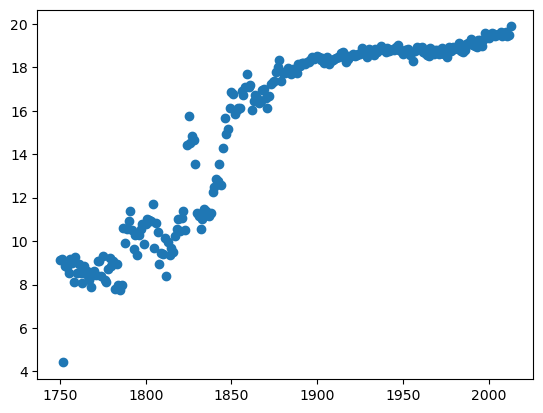

In [25]:
global_temps['Year'] = global_temps['Year'].astype(int)
plt.scatter(global_temps['Year'], global_temps['AverageTemperature'])
global_temps

Here we can clearly see that there is an upward trend, with the biggest spike in temperature occurring during the 1850s. Now we are going to try to use linear regression to fit a trend line to this data

0.8350672959938121

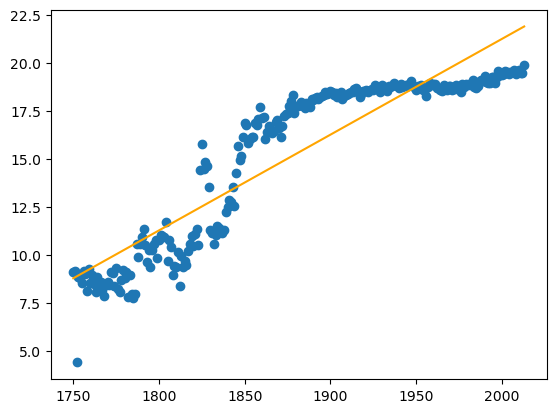

In [80]:
X = np.asarray(global_temps['Year'])
X = X.reshape(-1, 1)
y = global_temps['AverageTemperature']
model = LinearRegression().fit(X, y)
year_range = np.arange(1750, 2014, 1)
m = model.coef_
b = model.intercept_
temp_range = m * year_range + b
plt.plot(year_range, temp_range, 'orange')
plt.scatter(global_temps['Year'], global_temps['AverageTemperature'])
model.score(X, y)

Obviously, a normal linear regression does not fit this data well, so instead we are going to try to fit a polynomial curve to the data instead. In the cell below, we check to find what degree of polynomial fits best.

6

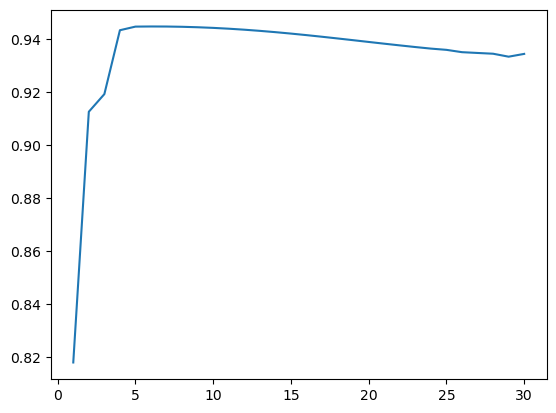

In [81]:
max_degree = 30
degrees = range(1, max_degree+1)
cv_scores = []
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
for d in degrees:
    X_poly_train = PolynomialFeatures(degree=d).fit_transform(X_train)
    X_poly_test = PolynomialFeatures(degree=d).fit_transform(X_test)
    model = LinearRegression().fit(X_poly_train, y_train)
    scores = cross_val_score(model, X_poly_train, y_train)
    cv_scores.append(np.mean(scores))
plt.plot(degrees, cv_scores)
best_degree = degrees[np.argmax(cv_scores)]
best_degree

Now that we know what degree to use, we fit the model and plot it. As shown below, this curve fits much better to the data and shows the upwards trend very well.

0.9665568867732375

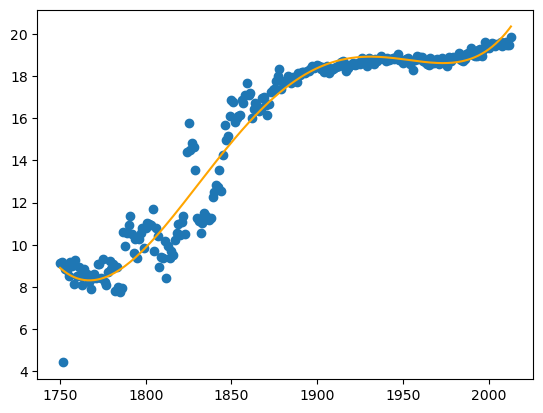

In [82]:
X_poly_train = PolynomialFeatures(degree=best_degree).fit_transform(X_train)
X_poly_test = PolynomialFeatures(degree=best_degree).fit_transform(X_test)
model = LinearRegression().fit(X_poly_train, y_train)
X_poly = PolynomialFeatures(degree=best_degree).fit_transform(X)
y_preds = model.predict(X_poly)
plt.plot(X, y_preds, 'orange')
plt.scatter(X, y)
model.score(X_poly_test, y_test)

Now we attempt to find a relationship between temperature and sea level. This time, we are going to use spark to batch the data which will allow for a much faster runtime than part one of this project.

In [1]:
# start up the spark context
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext()

In [2]:
# start spark session
session = SparkSession(sc)

In [3]:
# load in sea level csv
slevel_info = session.read.csv('./climate-change-data/Global_sea_level_rise.csv', inferSchema=True, header=True)
slevel_info.rdd.getNumPartitions()

1

In [4]:
slevel_info.show()

+----+----------+----------------------+
|year|      date|mmfrom1993-2008average|
+----+----------+----------------------+
|1880|07/15/1880|          -183.2473958|
|1881|07/15/1881|          -174.0140625|
|1882|07/15/1882|          -190.0807292|
|1883|07/15/1883|          -185.1473958|
|1884|07/15/1884|          -166.2807292|
|1885|07/15/1885|          -167.6807292|
|1886|07/15/1886|          -164.2140625|
|1887|07/15/1887|          -170.2140625|
|1888|07/15/1888|          -172.6140625|
|1889|07/15/1889|          -169.7140625|
|1890|07/15/1890|          -166.9807292|
|1891|07/15/1891|          -167.7140625|
|1892|07/15/1892|          -167.5807292|
|1893|07/15/1893|          -162.9807292|
|1894|07/15/1894|          -176.8807292|
|1895|07/15/1895|          -163.1473958|
|1896|07/15/1896|          -160.3140625|
|1897|07/15/1897|          -152.1473958|
|1898|07/15/1898|          -157.1140625|
|1899|07/15/1899|          -151.6807292|
+----+----------+----------------------+
only showing top

Again, we see the upwards trend in sea level that we expected to go along with the rise in global temperature

Text(0, 0.5, 'Sea Level (mm)')

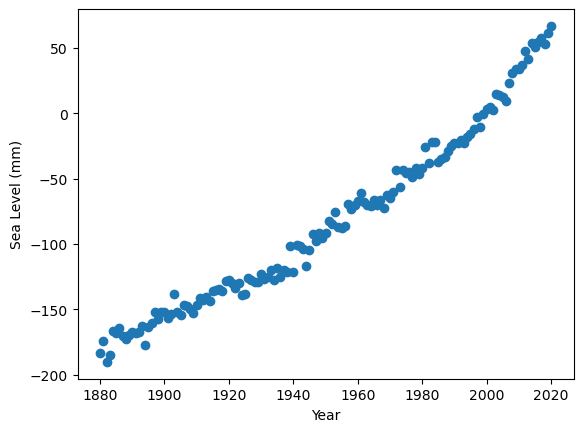

In [33]:
# grab info and plot scatter
slevel_pd = slevel_info.toPandas()
x0 = slevel_pd['year'].values.tolist()
y0 = slevel_pd['mmfrom1993-2008average'].values.tolist()

plt.scatter(x0, y0)
plt.xlabel("Year")
plt.ylabel("Sea Level (mm)")

Reading the global temp data in using spark, showing how much faster it is because of parallel computing.

In [9]:
# load in global temperatures data
gtemp_info = session.read.csv('./climate-change-data/GlobalTemperatures.csv', inferSchema=True, header=True)
gtemp_info.rdd.getNumPartitions()

1

In [10]:
gtemp_info.show()

+-------------------+----------------------+---------------------------------+------------------+-----------------------------+------------------+-----------------------------+------------------------------+-----------------------------------------+
|                 dt|LandAverageTemperature|LandAverageTemperatureUncertainty|LandMaxTemperature|LandMaxTemperatureUncertainty|LandMinTemperature|LandMinTemperatureUncertainty|LandAndOceanAverageTemperature|LandAndOceanAverageTemperatureUncertainty|
+-------------------+----------------------+---------------------------------+------------------+-----------------------------+------------------+-----------------------------+------------------------------+-----------------------------------------+
|1750-01-01 00:00:00|    3.0340000000000003|                            3.574|              null|                         null|              null|                         null|                          null|                                     null|


In [27]:
# reformat date into year
gtemp_pd = gtemp_info.toPandas()
x1 = gtemp_pd['dt'].dt.year.unique()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [31]:
y1 = []
for year in x1:
    subset_temp = gtemp_pd[gtemp_pd['dt'].dt.year == year]
    y1.append(np.mean(subset_temp['LandAndOceanAverageTemperature'].values.tolist()))

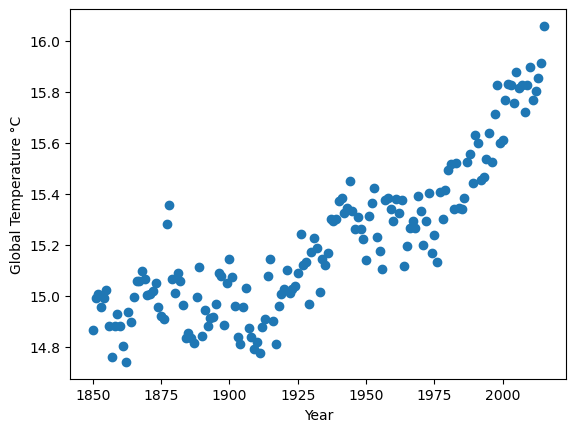

In [32]:
# scatter plot data
plt.scatter(x1, y1)
plt.xlabel("Year")
_=plt.ylabel(u"Global Temperature \N{DEGREE SIGN}C")

In [35]:
# plot sea level as a function of global temperature
start_year = 1880
end_year = 2013
x3 = []
y3 = []

for year in range(start_year, end_year):
    # calculate the average temperature for that year
    subset_temp = gtemp_pd[gtemp_pd['dt'].dt.year == year]
    x3.append(np.mean(subset_temp['LandAndOceanAverageTemperature'].values.tolist()))
    # gather sea level for that year
    subset_slevel = slevel_pd[slevel_pd['year'] == year]
    y3.append(subset_slevel['mmfrom1993-2008average'].values.tolist())

In [111]:
gtemp_subset = pd.DataFrame({"year": range(start_year, end_year)})
gtemp_subset["AvgTemp"] = x3
gtemp_subset.to_csv("./climate-change-data/GlobalAvgTemperature.csv")
gtemp_subset.head()

,year,AvgTemp
0,1880,15.008667
1,1881,15.087167
2,1882,15.056583
3,1883,14.963250
4,1884,14.833250


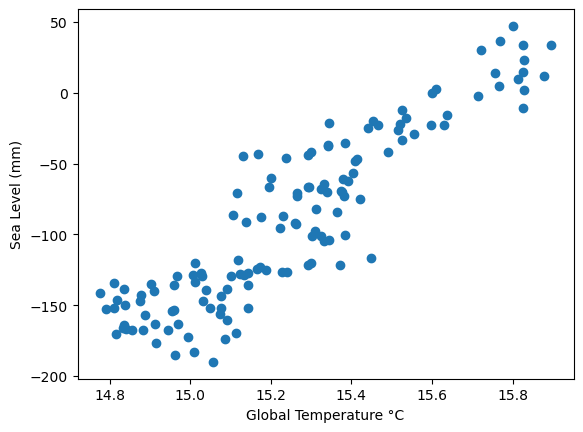

In [36]:
# scatter plot data
plt.scatter(x3, y3)
plt.xlabel(u"Global Temperature \N{DEGREE SIGN}C")
_=plt.ylabel("Sea Level (mm)")

As you can see there is a somewhat obvious correlation between the rise of global temperatures and the rise of the sea level

In [65]:
from pyspark.sql import functions as F
import datetime

gtemp_info = gtemp_info.withColumn('year', F.date_format(F.to_date(F.col('dt')), "yyyy"))

In [ ]:
#subset_temp = gtemp_pd[gtemp_pd['dt'].dt.year == year]
#x3.append(np.mean(subset_temp['LandAndOceanAverageTemperature'].values.tolist()))

In [104]:
year = 2010
subset_temp = gtemp_info.filter(F.col('year') == year)
subset_temp

DataFrame[dt: timestamp, LandAverageTemperature: double, LandAverageTemperatureUncertainty: double, LandMaxTemperature: double, LandMaxTemperatureUncertainty: double, LandMinTemperature: double, LandMinTemperatureUncertainty: double, LandAndOceanAverageTemperature: double, LandAndOceanAverageTemperatureUncertainty: double, year: string]

In [66]:
gtemp_info.show()

+-------------------+----------------------+---------------------------------+------------------+-----------------------------+------------------+-----------------------------+------------------------------+-----------------------------------------+----+
|                 dt|LandAverageTemperature|LandAverageTemperatureUncertainty|LandMaxTemperature|LandMaxTemperatureUncertainty|LandMinTemperature|LandMinTemperatureUncertainty|LandAndOceanAverageTemperature|LandAndOceanAverageTemperatureUncertainty|year|
+-------------------+----------------------+---------------------------------+------------------+-----------------------------+------------------+-----------------------------+------------------------------+-----------------------------------------+----+
|1750-01-01 00:00:00|    3.0340000000000003|                            3.574|              null|                         null|              null|                         null|                          null|                            

In [113]:
# load in average temperature data
avg_temp_info = session.read.csv('./climate-change-data/GlobalAvgTemperature.csv', inferSchema=True, header=True)

In [115]:
# join RDDs to use in regression
slevel_temp = slevel_info.join(avg_temp_info, slevel_info.year == avg_temp_info.year)

In [116]:
# rename sea level column to output for use in vector assembler
_ = slevel_temp = slevel_temp.withColumn('output', F.col('mmfrom1993-2008average'))

In [119]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# create vector assembler for regression
assembler = VectorAssembler().setInputCols(['AvgTemp']).setOutputCol('features')

# transform temperature and 
slevel_temp_vec = assembler.transform(slevel_temp).select(['features', 'output'])

# generate regression model
lr = LinearRegression().setFeaturesCol("features").setLabelCol("output")
slevel_temp_model = lr.fit(slevel_temp_vec)

In [120]:
model_summary = slevel_temp_model.summary
print("Summary of predicted arrival model")
print("RMSE: %f" % model_summary.rootMeanSquaredError)
print("r2: %f" % model_summary.r2)

Summary of predicted arrival model
RMSE: 25.838208
r2: 0.819446


In [121]:
# display information on the model
print("Coefficients: " + str(slevel_temp_model.coefficients))
print("Intercept: " + str(slevel_temp_model.intercept))
print("Dataframe shape: " + str(slevel_temp.count()) + ", " + str(len(slevel_temp.columns)))

Coefficients: [193.11313114346154]
Intercept: -3034.7438487388054
Dataframe shape: 133, 7


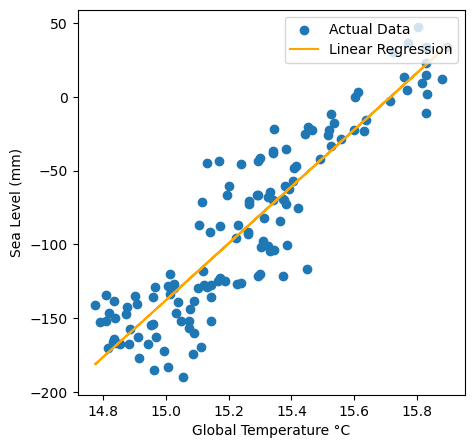

In [122]:
# plot regression
x4 = np.array(x3)
y4 = x4 * slevel_temp_model.coefficients[0] + slevel_temp_model.intercept
    
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(x3, y3, label='Actual Data')
ax.plot(x4, y4, label='Linear Regression', c='orange')
plt.xlabel(u"Global Temperature \N{DEGREE SIGN}C")
_=plt.ylabel("Sea Level (mm)")
plt.legend(loc='upper right')

In conclusion, we were able to find a very strong correlation between global temperatures and sea level rise, just as we had predicted at the beginning. Being able to take two datasets that were collected completely independently and still being able to find a correlation allows us to be very confident in our findings. This project also showed us how much of an impact using a library like spark can help, as the manual batching took significantly longer than the parallel nodes that spark allows us to take advantage of.